Notebook for https://github.com/Aayushjn/OS-ELM

In [1]:
import numpy as np
from implementations.elm import OS_ELM
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
path = "../datasets/"

In [2]:
def soft_max(a):
    c = np.max(a, axis=-1).reshape(-1, 1)
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a, axis=-1).reshape(-1, 1)
    return exp_a / sum_exp_a

def metrics(true,predicted):
    CM = confusion_matrix(predicted, true)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    a = (TP + TN) / (TP + TN + FP + FN)
    f1 = ( 2*( p*r )) / (p + r)
    print("Precision =",p)
    print("Recall =",r)
    print("Accuracy =",a)
    print("F1 =",f1)

sequential training phase: 100%|███████████████████████████████████████████████| 16346/16346 [00:01<00:00, 9103.28it/s]



val_loss: 1.9449521819210889, val_accuracy: 5.554%

val_loss: 1.9449668341142046, val_accuracy: 5.554%

val_loss: 1.944971759606011, val_accuracy: 5.554%

val_loss: 1.9449742274715278, val_accuracy: 5.554%

val_loss: 1.944975710131887, val_accuracy: 5.554%

val_loss: 1.9449767001789549, val_accuracy: 5.554%

val_loss: 1.9449774073343191, val_accuracy: 5.554%

val_loss: 1.9449779383279657, val_accuracy: 5.554%

val_loss: 1.9449783514556267, val_accuracy: 5.554%

val_loss: 1.9449786820156862, val_accuracy: 5.554%

val_loss: 1.944978952554121, val_accuracy: 5.554%

val_loss: 1.9449791780307832, val_accuracy: 5.554%


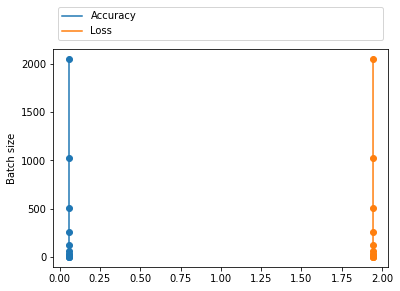

In [4]:
dataset = "hs.csv"

n_input_nodes = 9
n_hidden_nodes = 11
n_output_nodes = 5


os_elm = OS_ELM(n_input_nodes=n_input_nodes,
                n_hidden_nodes=n_hidden_nodes,
                n_output_nodes=n_output_nodes)

# Load data
data = read_csv(path + dataset)
# Encode classes to 0 - n_classes
data['ocean_proximity'] = LabelEncoder().fit_transform(data['ocean_proximity'].astype('str'))
# Split data to inputs and class labels
x = data.iloc[:, :data.shape[1] - 1]
t = data.iloc[:, data.shape[1] - 1]

# Data normalization
for val in x:
    x[val] /= 500001

x_train, x_test, t_train, t_test = train_test_split(x, t, train_size=0.8, test_size=0.2)

# Divide the dataset into two parts:-
#   (1) for the initial training phase
#   (2) for the sequential training phase
# NOTE: The number of training samples for the initial training phase
# must be much greater than the number of the model's hidden nodes.
# Here we assign int(1.5 * n_hidden_nodes) training samples
# for the initial training phase.
border = int(1.5 * n_hidden_nodes)
x_train_init = x_train.values[:border]
x_train_seq = x_train.values[border:]
t_train_init = t_train.values[:border]
t_train_seq = t_train.values[border:]

# ========== Initial training phase ==========

progress_bar = tqdm(total=len(x_train), desc='initial training phase')
os_elm.init_train(x_train_init, t_train_init)
progress_bar.update(len(x_train_init))

batch_sizes = []
accuracies = []
losses = []

for p in range(12):
    batch_size = 2 ** p

    # ========== Sequential training phase ==========
    progress_bar.set_description('sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i: i + batch_size]
        t_batch = t_train_seq[i: i + batch_size]
        os_elm.seq_train(x_batch, t_batch)
        progress_bar.update(len(x_batch))
    progress_bar.close()

    # Sample 'n' samples from the x_test
    n = len(x_test.values)
    x = x_test.values[:n]
    t = t_test.values[:n]

    y = os_elm.predict(x)
    y = soft_max(y)
    
    
    # Check the answers
    for i in range(n):
        max_ind = np.argmax(y.flatten()[i])
        #print('======== sample index {} ========'.format(i))
        #print('estimated answer: class {}'.format(max_ind))
        #print('estimated probability: {}'.format(y[max_ind][i]))
        #print('true answer: class {}'.format(t[i]))

    # Evaluate 'loss' and 'accuracy' metrics for the model
    [loss, accuracy] = os_elm.evaluate(x_test.values, t_test.values, metrics=['loss', 'accuracy'])
    print('\nval_loss: {}, val_accuracy: {:.3f}%'.format(loss, accuracy * 100))

    batch_sizes.append(batch_size)
    accuracies.append(accuracy)
    losses.append(loss)
    
plt.scatter(accuracies, batch_sizes)
plt.plot(accuracies, batch_sizes)
plt.scatter(losses, batch_sizes)
plt.plot(losses, batch_sizes)
plt.ylabel("Batch size")
plt.legend(["Accuracy", "Loss"], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand")
plt.show()



sequential training phase: 100%|█████████████████████████████████████████████████| 3341/3341 [00:00<00:00, 8883.36it/s]



val_loss: 0.6931702482831554, val_accuracy: 29.545%

val_loss: 0.6933200392040885, val_accuracy: 29.904%

val_loss: 0.693374720126456, val_accuracy: 29.545%

val_loss: 0.6934029814438387, val_accuracy: 29.426%

val_loss: 0.6934202074683871, val_accuracy: 29.426%

val_loss: 0.6934318060218365, val_accuracy: 29.545%

val_loss: 0.6934401563601832, val_accuracy: 29.545%

val_loss: 0.6934464516877414, val_accuracy: 29.545%

val_loss: 0.693451367043761, val_accuracy: 29.545%


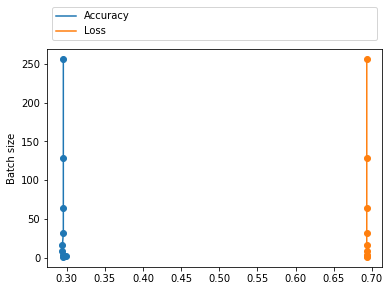

In [6]:
dataset = "Abalone.csv"
n_input_nodes = 8
n_hidden_nodes = 16
n_output_nodes = 3

os_elm = OS_ELM(n_input_nodes=n_input_nodes,
                n_hidden_nodes=n_hidden_nodes,
                n_output_nodes=n_output_nodes)

# Load data
data = read_csv(path + dataset)
# Encode classes to 0 - n_classes
data['sex'] = LabelEncoder().fit_transform(data['sex'].astype('str'))
# Split data to inputs and class labels
x = data.iloc[:, :data.shape[1] - 1]
t = data.iloc[:, data.shape[1] - 1]

# Data normalization
for val in x:
    x[val] /= 29

x_train, x_test, t_train, t_test = train_test_split(x, t, train_size=0.8, test_size=0.2)

# Divide the dataset into two parts:-
#   (1) for the initial training phase
#   (2) for the sequential training phase
# NOTE: The number of training samples for the initial training phase
# must be much greater than the number of the model's hidden nodes.
# Here we assign int(1.5 * n_hidden_nodes) training samples
# for the initial training phase.
border = int(1.5 * n_hidden_nodes)
x_train_init = x_train.values[:border]
x_train_seq = x_train.values[border:]
t_train_init = t_train.values[:border]
t_train_seq = t_train.values[border:]

# ========== Initial training phase ==========
progress_bar = tqdm(total=len(x_train), desc='initial training phase')
os_elm.init_train(x_train_init, t_train_init)
progress_bar.update(len(x_train_init))

batch_sizes = []
accuracies = []
losses = []

for p in range(9):
    batch_size = 2 ** p

    # ========== Sequential training phase ==========
    progress_bar.set_description('sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i: i + batch_size]
        t_batch = t_train_seq[i: i + batch_size]
        os_elm.seq_train(x_batch, t_batch)
        progress_bar.update(len(x_batch))
    progress_bar.close()

    # Sample 'n' samples from the x_test
    n = len(x_test.values)
    x = x_test.values[:n]
    t = t_test.values[:n]

    y = os_elm.predict(x)
    y = soft_max(y)

    # Check the answers
    #for i in range(n):
        #max_ind = np.argmax(y.flatten()[i])
        #print('======== sample index {} ========'.format(i))
        #print('estimated answer: class {}'.format(max_ind))
        #print('estimated probability: {}'.format(y[max_ind][i]))
        #print('true answer: class {}'.format(t[i]))

    # Evaluate 'loss' and 'accuracy' metrics for the model
    [loss, accuracy] = os_elm.evaluate(x_test.values, t_test.values, metrics=['loss', 'accuracy'])
    print('\nval_loss: {}, val_accuracy: {:.3f}%'.format(loss, accuracy * 100))

    batch_sizes.append(batch_size)
    accuracies.append(accuracy)
    losses.append(loss)

plt.scatter(accuracies, batch_sizes)
plt.plot(accuracies, batch_sizes)
plt.scatter(losses, batch_sizes)
plt.plot(losses, batch_sizes)
plt.ylabel("Batch size")
plt.legend(["Accuracy", "Loss"], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand")
plt.show()

In [39]:
dataset = "Pokemon.csv"


n_input_nodes = 10
n_hidden_nodes = 128
n_output_nodes = 305

os_elm = OS_ELM(n_input_nodes=n_input_nodes,
                n_hidden_nodes=n_hidden_nodes,
                n_output_nodes=n_output_nodes)

# Load data
data = pd.read_csv('../datasets/Pokemon.csv')
data = data.set_index("#")

d = {}
for i in range(len(data["Type 2"].unique())):
  d[data["Type 2"].unique()[i]] = i + 1
data = data.drop(columns = ["Name"])
data = data.fillna(0)
data["Type 2"] = data["Type 2"].replace(d)


data_balanced = data[(data["Type 1"] == "Water") | (data["Type 1"] == "Normal") | (data["Type 1"] == "Grass")]


x = data_balanced.iloc[:,1:]
t = data_balanced.iloc[:,0]


x_train, x_test, t_train, t_test = train_test_split(x, t, train_size=0.8, test_size=0.2)

# Divide the dataset into two parts:-
#   (1) for the initial training phase
#   (2) for the sequential training phase
# NOTE: The number of training samples for the initial training phase
# must be much greater than the number of the model's hidden nodes.
# Here we assign int(1.5 * n_hidden_nodes) training samples
# for the initial training phase.
border = int(1.5 * n_hidden_nodes)
x_train_init = x_train.values[:border]
x_train_seq = x_train.values[border:]
t_train_init = t_train.values[:border]
t_train_seq = t_train.values[border:]
print(len(x),border,len(x_train),len(t_train),len(x_train_seq))

# ========== Initial training phase ==========
progress_bar = tqdm(total=len(x_train), desc='initial training phase')
os_elm.init_train(x_train_init, t_train_init)
progress_bar.update(len(x_train_init))

batch_sizes = []
accuracies = []
losses = []

for p in range(8):
    batch_size = 2 ** p

    # ========== Sequential training phase ==========
    progress_bar.set_description('sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i: i + batch_size]
        t_batch = t_train_seq[i: i + batch_size]
        os_elm.seq_train(x_batch, t_batch)
        progress_bar.update(len(x_batch))
    progress_bar.close()

    # Sample 'n' samples from the x_test
    n = len(x_test.values)
    x = x_test.values[:n]
    t = t_test.values[:n]

    y = os_elm.predict(x)
    y = soft_max(y)

    # Check the answers
    #for i in range(n):
        #max_ind = np.argmax(y.flatten()[i])
        #print('======== sample index {} ========'.format(i))
        #print('estimated answer: class {}'.format(max_ind))
        #print('estimated probability: {}'.format(y[max_ind, i]))
        #print('true answer: class {}'.format(t[i]))

    # Evaluate 'loss' and 'accuracy' metrics for the model
    [loss, accuracy] = os_elm.evaluate(x_test.values, t_test.values, metrics=['loss', 'accuracy'])
    print('\nval_loss: {}, val_accuracy: {:.3f}%'.format(loss, accuracy * 100))

    batch_sizes.append(batch_size)
    accuracies.append(accuracy)
    losses.append(loss)

plt.scatter(accuracies, batch_sizes)
plt.plot(accuracies, batch_sizes)
plt.scatter(losses, batch_sizes)
plt.plot(losses, batch_sizes)
plt.ylabel("Batch size")
plt.legend(["Accuracy", "Loss"], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand")
plt.show()

initial training phase:   0%|                                                                  | 0/224 [00:00<?, ?it/s]

280 192 224 224 32


TypeError: loop of ufunc does not support argument 0 of type float which has no callable exp method

sequential training phase: 100%|███████████████████████████████████████████████████| 120/120 [00:00<00:00, 4443.39it/s]

150 150 120 120

val_loss: 57.39349883456906, val_accuracy: 23.333%

val_loss: 57.39349883456906, val_accuracy: 23.333%

val_loss: 57.39349883456906, val_accuracy: 23.333%

val_loss: 57.39349883456906, val_accuracy: 23.333%

val_loss: 57.39349883456906, val_accuracy: 23.333%

val_loss: 57.39349883456906, val_accuracy: 23.333%

val_loss: 57.39349883456906, val_accuracy: 23.333%


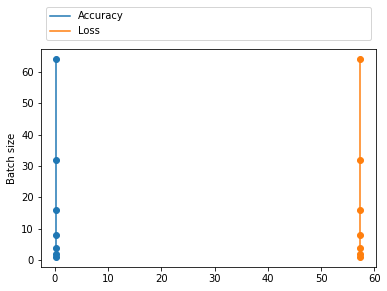

In [71]:
#IRIS DATASET

dataset = "iris.csv"


n_input_nodes = 4
n_hidden_nodes = 100
n_output_nodes = 3

os_elm = OS_ELM(n_input_nodes=n_input_nodes,
                n_hidden_nodes=n_hidden_nodes,
                n_output_nodes=n_output_nodes)

# Load data
data = read_csv(path + dataset)
# Encode classes to 0 - n_classes
data['species'] = LabelEncoder().fit_transform(data['species'].astype('str'))
# Split data to inputs and class labels
x = data.iloc[:, :data.shape[1] - 1]
t = data.iloc[:, data.shape[1] - 1]


x_train, x_test, t_train, t_test = train_test_split(x, t, train_size=0.8, test_size=0.2)

# Divide the dataset into two parts:-
#   (1) for the initial training phase
#   (2) for the sequential training phase
# NOTE: The number of training samples for the initial training phase
# must be much greater than the number of the model's hidden nodes.
# Here we assign int(1.5 * n_hidden_nodes) training samples
# for the initial training phase.
border = int(1.5 * n_hidden_nodes)
x_train_init = x_train.values[:border]
x_train_seq = x_train.values[border:]
t_train_init = t_train.values[:border]
t_train_seq = t_train.values[border:]
print(len(x),border,len(x_train),len(t_train))

# ========== Initial training phase ==========
progress_bar = tqdm(total=len(x_train), desc='initial training phase')
os_elm.init_train(x_train_init, t_train_init)
progress_bar.update(len(x_train_init))

batch_sizes = []
accuracies = []
losses = []

for p in range(7):
    batch_size = 2 ** p

    # ========== Sequential training phase ==========
    progress_bar.set_description('sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i: i + batch_size]
        t_batch = t_train_seq[i: i + batch_size]
        os_elm.seq_train(x_batch, t_batch)
        progress_bar.update(len(x_batch))
    progress_bar.close()

    # Sample 'n' samples from the x_test
    n = len(x_test.values)
    x = x_test.values[:n]
    t = t_test.values[:n]

    y = os_elm.predict(x)
    y = soft_max(y)

    # Check the answers
    #for i in range(n):
        #max_ind = np.argmax(y.flatten()[i])
        #print('======== sample index {} ========'.format(i))
        #print('estimated answer: class {}'.format(max_ind))
        #print('estimated probability: {}'.format(y[max_ind, i]))
        #print('true answer: class {}'.format(t[i]))

    # Evaluate 'loss' and 'accuracy' metrics for the model
    [loss, accuracy] = os_elm.evaluate(x_test.values, t_test.values, metrics=['loss', 'accuracy'])
    print('\nval_loss: {}, val_accuracy: {:.3f}%'.format(loss, accuracy * 100))

    batch_sizes.append(batch_size)
    accuracies.append(accuracy)
    losses.append(loss)

plt.scatter(accuracies, batch_sizes)
plt.plot(accuracies, batch_sizes)
plt.scatter(losses, batch_sizes)
plt.plot(losses, batch_sizes)
plt.ylabel("Batch size")
plt.legend(["Accuracy", "Loss"], bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand")
plt.show()